First let's consider an oracle made of a function which takes 1 bit as the input

In [4]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

n=1

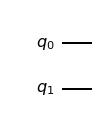

In [11]:

const_oracle1 = QuantumCircuit(2)


#constant oracle 1 --- identity 

const_oracle1.draw()




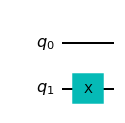

In [7]:
# constant oracle 2 
const_oracle2 = QuantumCircuit(2)

const_oracle2.x(1)

const_oracle2.draw()

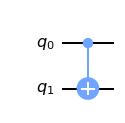

In [12]:
balanced_oracle1= QuantumCircuit(2)
#balanced_oracle2= QuantumCircuit(2)
balanced_oracle1.cx(0,1)
balanced_oracle1.draw()

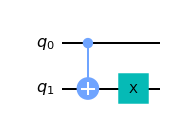

In [14]:
balanced_oracle2=QuantumCircuit(2)
balanced_oracle2.cx(0,1)
balanced_oracle2.x(1)
balanced_oracle2.draw()

Choosing 4 possible oracles to understand the quantum algorithm

In [22]:
# chosing the oracle to simulate 
# select one of these and comment the rest

#oracleF= const_oracle1
oracleF= const_oracle2
# oracleF= balanced_oracle1
#oracleF= balanced_oracle2

/tmp/ipykernel_135/1700680483.py:14: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += oracleF


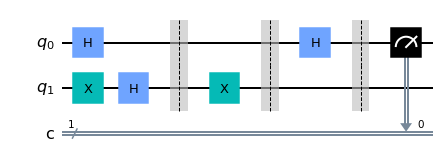

In [23]:
dj_circuit = QuantumCircuit(2, 1)

# Apply H-gates
for qubit in range(1):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(1)
dj_circuit.h(1)

dj_circuit.barrier()

# Add oracle
dj_circuit += oracleF

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(1):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(1):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

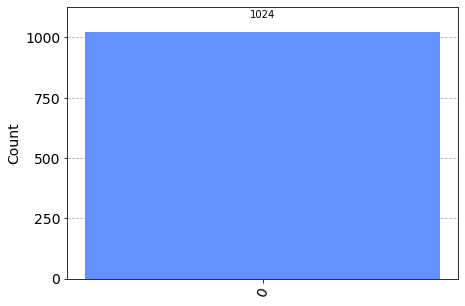

In [24]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Now we will look at a generalized version 

Reference : https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html

In [1]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [2]:
# create circuit

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

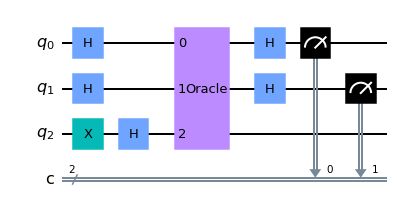

In [11]:
n = 2
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

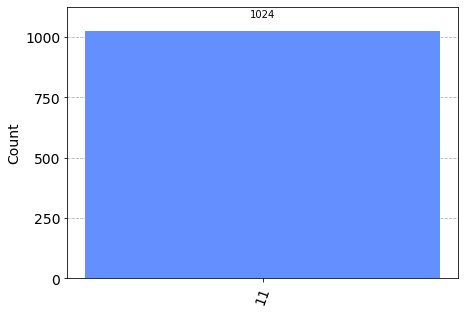

In [12]:
# simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

With real quantum devices 

In [17]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2023-01-13 07:07:59,304: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem


In [15]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


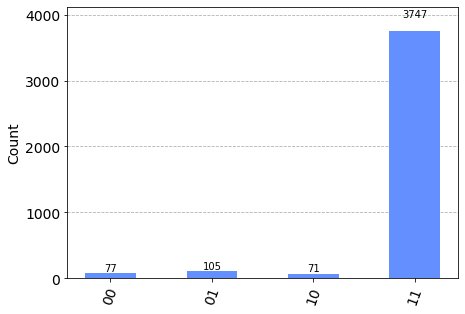

In [16]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Similarly, for a constant function

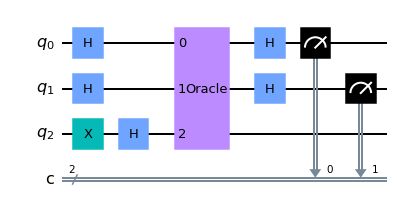

In [18]:
n = 2
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

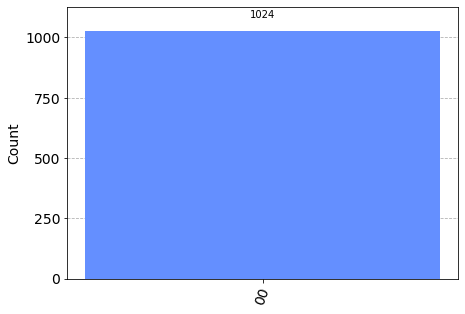

In [19]:
# simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

In [20]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
#IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibm_oslo


In [21]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


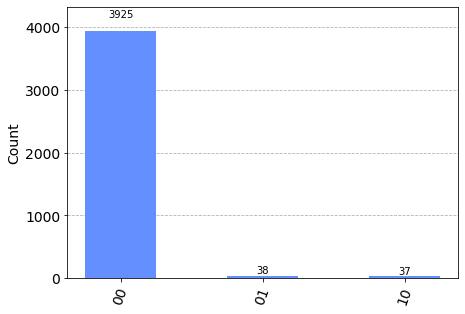

In [22]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)